**LIBRARIES**

---






In [18]:
import scipy as sp
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import datetime as dt
from numpy import set_printoptions
from scipy.ndimage import interpolation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC

  

**LOADING THE DATASET**

---




In [19]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

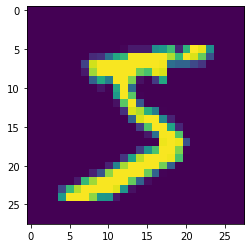

In [20]:
plt.imshow(X[0].reshape(28,28))

**DATA PREPROCESSING**

---

According to most literature available, handwriting classification models based on Support Vector Machines (SVM) greatly benefit from deskewing, that is the straightening of the numbers in the images.    
Therefore, all the images in the dataset were processed with deskewing, using the method available at https://fsix.github.io/mnist/Deskewing.html








In [21]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


The results of deskewing can be appreciated in the images below

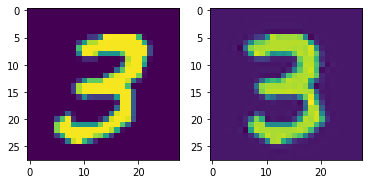

In [22]:
plt.subplot(1, 2, 1)
plt.imshow(X[7].reshape(28,28))

newim = deskew(X[7].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)

In [23]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X_deskewed = deskewAll(X)

Each feature is then transformed by rescaling to a value between 0 and 1

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X_deskewed)

The dataset is split into training and testing sets, with a test size 15% of the total

In [53]:
x_train, x_test, y_train, y_test = train_test_split(rescaledX, y, test_size=0.3, random_state=42)
data = {"train": {"X": x_train, "Y": y_train}, "test": {"X": x_test, "Y": y_test},}

In [26]:
samplesize = len(data["train"]["X"])

In [27]:
#poly-9 degrees are used with virtual svms (virtualized data)
#mnist_classifier = SVC(probability=False, kernel="poly", degree=9, C =2, gamma=0.01)

**PARAMETER TUNING**


---

The main parameters considered in the tuning of the model are:


*   **C** -> Regularization parameter
*   **kernel** -> kernel type used in the algorithm
*   **gamma** -> kernel coefficient

The only kernel considered for now is the RBF (or Gaussian) kernel; the C and gamma parameters will be selected with the grid search method.

In [28]:
gamma_range = [0.0001, 0.01, 1.0, 10]
C_range = [0.1, 1, 10, 50, 100]
parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}

In [29]:
gamma_range

[0.0001, 0.01, 1.0, 10]

In [30]:
C_range

[0.1, 1, 10, 50, 100]

In [61]:
svm_clf = svm.SVC(cache_size = 1000)
grid_clf = GridSearchCV(estimator=svm_clf,param_grid=parameters, cv = 3, n_jobs=7, verbose=10)

In [62]:
start_time = dt.datetime.now()
print('Start param searching at {}'.format(str(start_time)))

Start param searching at 2020-10-05 17:48:50.105303


In [63]:
grid_clf.fit(data["train"]["X"][:samplesize], data["train"]["Y"][:samplesize])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    5.2s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    9.2s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   19.5s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   27.0s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   34.6s
[Parallel(n_jobs=7)]: Done  54 out of  60 | elapsed:   36.7s remaining:    4.1s
[Parallel(n_jobs=7)]: Done  60 out of  60 | elapsed:   40.6s finished


GridSearchCV(cv=3, estimator=SVC(cache_size=500), n_jobs=7,
             param_grid={'C': [0.1, 1, 10, 50, 100],
                         'gamma': [0.0001, 0.01, 1.0, 10], 'kernel': ['rbf']},
             verbose=10)

In [34]:
elapsed_time= dt.datetime.now() - start_time
print('Elapsed time, param searching {}'.format(str(elapsed_time)))

Elapsed time, param searching 0:00:40.868493


Best parameters:
10000 samples: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [35]:
#print(grid_clf.cv_results_.keys())

classifier = grid_clf.best_estimator_
params = grid_clf.best_params_
scores = grid_clf.cv_results_['mean_test_score']

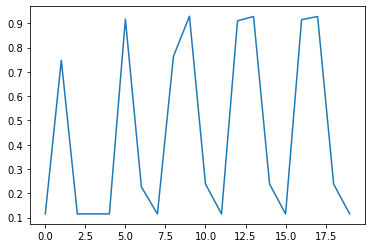

In [36]:
plt.plot(scores)

In [37]:
print("Best performing classifier:\n" + str(classifier))
print("\nBest parameters:\n" + str(params))
print("\nAll test scores:\n" + str(scores))

Best performing classifier:
SVC(C=10, cache_size=1000, gamma=0.01)

Best parameters:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

All test scores:
[0.115 0.748 0.115 0.115 0.115 0.917 0.226 0.115 0.764 0.929 0.238 0.115
 0.91  0.928 0.238 0.115 0.915 0.928 0.238 0.115]


In [38]:
#grid_clf.cv_results_

In [39]:
#predicted = grid_clf.predict(data["test"]["X"])
#print("Confusion matrix:\n%s" % metrics.confusion_matrix(data["test"]["Y"], predicted))
#print("Accuracy: %0.4f" % metrics.accuracy_score(data["test"]["Y"], predicted))


Accuracy: 0.9450


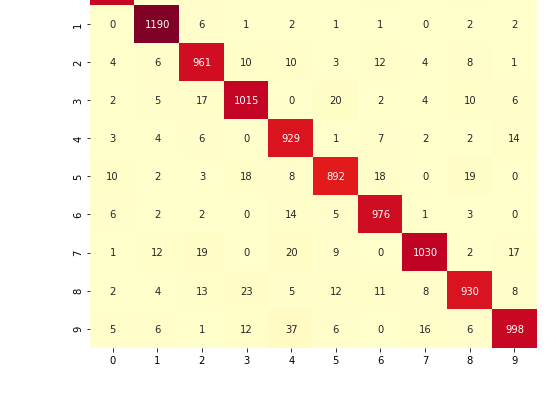

In [40]:
predicted = grid_clf.predict(data["test"]["X"])
df_cm = pd.DataFrame(metrics.confusion_matrix(data["test"]["Y"], predicted))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlOrRd", fmt="d")
print("Accuracy: %0.4f" % metrics.accuracy_score(data["test"]["Y"], predicted))

In [41]:
#print(sklearn.metrics.matthews_corrcoef(y_pred, data["test"]["Y"]))

In [42]:
params_df = pd.concat([pd.DataFrame(grid_clf.cv_results_["params"]),pd.DataFrame(grid_clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [43]:
params_df

,C,gamma,kernel,Accuracy
0,0.1,0.0001,rbf,0.115
1,0.1,0.0100,rbf,0.748
2,0.1,1.0000,rbf,0.115
3,0.1,10.0000,rbf,0.115
4,1.0,0.0001,rbf,0.115
5,1.0,0.0100,rbf,0.917
6,1.0,1.0000,rbf,0.226
7,1.0,10.0000,rbf,0.115
8,10.0,0.0001,rbf,0.764
9,10.0,0.0100,rbf,0.929


In [44]:
print("Best parameters set found on development set:")
print()
print(grid_clf.best_params_)
print()

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}



In [45]:
means = grid_clf.cv_results_['mean_test_score']
stds = grid_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
  print("%0.3f (+/-%0.03f) with %r" % (mean, std * 2, params))

0.115 (+/-0.000) with {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.748 (+/-0.024) with {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.115 (+/-0.000) with {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.115 (+/-0.000) with {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
0.115 (+/-0.000) with {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.917 (+/-0.025) with {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.226 (+/-0.070) with {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}
0.115 (+/-0.000) with {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.764 (+/-0.017) with {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.929 (+/-0.016) with {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.238 (+/-0.072) with {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}
0.115 (+/-0.000) with {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.910 (+/-0.028) with {'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}
0.928 (+/-0.010) with {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
0.238 (+/-0.072) with {'C': 50, 'gamma': 1.0, 'kernel': 'rbf'}
0.115 (+/-0.000) with {'C': 50, 'gamma': 1

In [46]:
# best parameters: {'C': 5.0, 'gamma': 0.05, 'kernel': 'rbf'}
mnist_classifier = SVC(probability=False, kernel="rbf", C=100, gamma=0.01)
mnist_classifier.fit(data["train"]["X"][:samplesize], data["train"]["Y"][:samplesize])

SVC(C=100, gamma=0.01)

In [47]:
predicted = mnist_classifier.predict(data["test"]["X"])
print("Confusion matrix:\n%s" % metrics.confusion_matrix(data["test"]["Y"], predicted))
print("Accuracy: %0.4f" % metrics.accuracy_score(data["test"]["Y"], predicted))

# try_id = 1
#out = clf.predict(data["test"]["X"][try_id])  # clf.predict_proba
#print("out: %s" % out)
#size = int(len(data["test"]["X"][try_id]) ** (0.5))
#view_image(
#    data["test"]["X"][try_id].reshape((size, size)), data["test"]["y"][try_id]
#)'''

Confusion matrix:
[[1030    0    3    1    0    0    0    0    1    0]
 [   0 1196    3    0    0    0    0    3    1    2]
 [   3    4  998    2    2    2    0    3    5    0]
 [   0    2    8 1062    0    3    0    1    3    2]
 [   0    1    3    0  957    0    1    2    1    3]
 [   0    0    1    7    0  956    4    0    1    1]
 [   2    0    1    1    5    4  996    0    0    0]
 [   0    0    8    0    3    1    0 1097    0    1]
 [   0    3    3    9    1    4    3    3  985    5]
 [   3    0    1    5    8    2    0    5    5 1058]]
Accuracy: 0.9843


In [48]:
metrics.matthews_corrcoef(data["test"]["Y"], predicted)


0.9825348204162511

In [49]:
print(metrics.classification_report(data["test"]["Y"], predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1035
           1       0.99      0.99      0.99      1205
           2       0.97      0.98      0.97      1019
           3       0.98      0.98      0.98      1081
           4       0.98      0.99      0.98       968
           5       0.98      0.99      0.98       970
           6       0.99      0.99      0.99      1009
           7       0.98      0.99      0.99      1110
           8       0.98      0.97      0.98      1016
           9       0.99      0.97      0.98      1087

    accuracy                           0.98     10500
   macro avg       0.98      0.98      0.98     10500
weighted avg       0.98      0.98      0.98     10500



In [50]:
#poly_parameters = {'kernel':['poly'], 'degree':[8,9], 'C':C_range, 'gamma': gamma_range}
#poly_grid_clf = GridSearchCV(estimator=svm_clf,param_grid=poly_parameters, n_jobs=7, verbose=2)
#poly_grid_clf.fit(data["train"]["X"][:1000], data["train"]["Y"][:1000])


In [51]:
#poly_predicted = poly_grid_clf.predict(data["test"]["X"])
#df_cm = pd.DataFrame(metrics.confusion_matrix(data["test"]["Y"], poly_predicted))
#plt.figure(figsize = (10,7))
#sns.heatmap(df_cm, annot=True, cmap="YlOrRd", fmt="d")
#print("Accuracy: %0.4f" % metrics.accuracy_score(data["test"]["Y"], poly_predicted))

In [52]:
#print(poly_grid_clf.best_params_)